In [10]:
from glob import glob
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torchtext
import torch

from utils import tokenizer_with_preprocessing
from trainer import Trainer

LOG_DIR = os.path.join('.', 'logs')
NEWS_PATH = os.path.join('..', 'data', 'news')

In [34]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_length', type=int, default=1000)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--n_epochs', type=int, default=100)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=10)
parser.add_argument('--num_actions', type=int, default=1)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=100)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.97)
parser.add_argument('--learning_rate', type=float, default=2.5e-4)

parser.add_argument('--test', action='store_true')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

# QR-DQN
parser.add_argument('--num_quantile', type=int, default=51)

args = parser.parse_args(args=[])

torch.backends.cudnn.benchmark = True

# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing,
                            use_vocab=True, lower=True, include_lengths=True,
                            batch_first=True, fix_length=args.max_length,
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

train_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

val_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_val.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
val_ds = val_ds[0]

test_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_test.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
test_ds = test_ds[0]

TEXT.build_vocab(train_ds, min_freq=10)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=1, train=True, shuffle=False)
val_dl = torchtext.data.Iterator(
    val_ds, batch_size=1, train=True, shuffle=False)
test_dl = torchtext.data.Iterator(
    test_ds, batch_size=1, train=True, shuffle=False)

trainer = Trainer(args, TEXT, train_dl)
trainer.load_model()

#  シミュレーション

## 通常

In [12]:
dist_hist = []
reward_hist = []

dist_hist, rewards_hist = trainer.evaluation(test_dl)

dist_hist = np.array(dist_hist).reshape(-1, args.num_actions, args.num_quantile)
reward_hist = np.array(rewards_hist).reshape(-1, 1)

                     train_reward:  4.435048488900065


## 期待値が正の場合のみ

In [13]:
actions = np.where(np.sum(dist_hist, axis=2) > 0, 1, 0)
epi_rewards = (reward_hist * actions)
print('勝率:', len(epi_rewards[epi_rewards > 0]) 
                      / len(epi_rewards[epi_rewards != 0]))
print('利益:', epi_rewards[epi_rewards > 0].sum())
print('損失:', epi_rewards[epi_rewards < 0].sum())

勝率: 0.5024752475247525
利益: 234.34945308510214
損失: -229.91440459620208


In [14]:
thred_list = []
reward_list = []
win_list = []

for thred in np.arange(-2, 2, 0.001):
    actions = np.where(np.sum(dist_hist, axis=2) > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()
    win_list.append(sum(reward_hist * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    reward_list.append(epi_rewards)

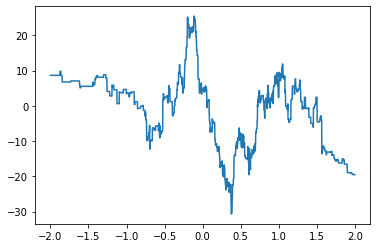

In [15]:
plt.plot(thred_list, reward_list)

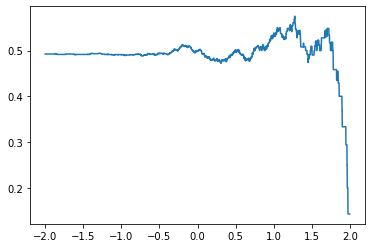

In [16]:
plt.plot(thred_list, win_list)

## Sharpe Ratio

In [17]:
thred = 1
sr = dist_hist.mean(axis=2) / dist_hist.std(axis=2)
actions = np.where(sr > thred, 1, 0)
epi_rewards = (reward_hist * actions)
print('勝率:', len(epi_rewards[epi_rewards > 0]) 
                      / len(epi_rewards[epi_rewards != 0]))
print('利益:', epi_rewards[epi_rewards > 0].sum())
print('損失:', epi_rewards[epi_rewards < 0].sum())

勝率: 0.4807121661721068
利益: 190.15721692238003
損失: -212.82379840966314


In [18]:
thred_list = []
reward_list = []
win_list = []
sr = dist_hist.mean(axis=2) / dist_hist.std(axis=2)

for thred in np.arange(-10, 10, 0.01):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()
    win_list.append(sum(reward_hist * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    reward_list.append(epi_rewards)

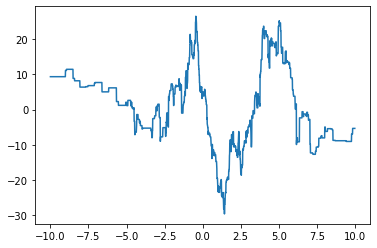

In [19]:
plt.plot(thred_list, reward_list)

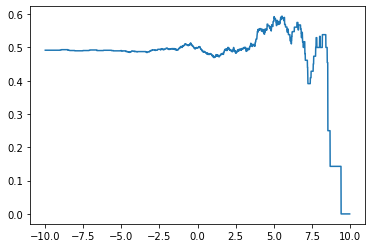

In [20]:
plt.plot(thred_list, win_list)

## distの最小値がthred以下の時

In [21]:
thred_list = []
reward_list = []
win_list = []
minv = dist_hist.min(axis=2)

for thred in np.arange(-0.05, 0.05, 0.00005):
    actions = np.where(minv > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()
    win_list.append(sum(reward_hist * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    reward_list.append(epi_rewards)

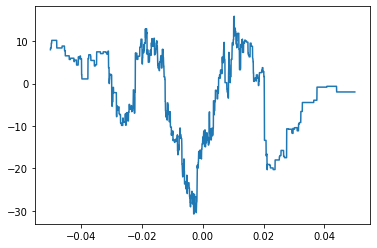

In [22]:
plt.plot(thred_list, reward_list)

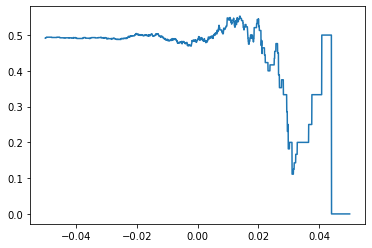

In [23]:
plt.plot(thred_list, win_list)

# VaR

In [24]:
thred_list = []
reward_list = []
minv = dist_hist.min(axis=2)

for thred in np.arange(-0.1, 0.1, 0.00001):
    actions = np.where(minv > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()

    thred_list.append(thred)
    reward_list.append(epi_rewards)

In [25]:
# dist_hist = []
# reward_hist = []
# action_hist = []
# epi_rewards = 0

# for batch in val_dl:
#     state = batch.Text1[0].to(trainer.device)
#     reward = batch.Label.to(trainer.device)
    
#     with torch.no_grad():
#         dist = trainer.model(state) * trainer.quantile_weight
#         dist_hist.append(dist.cpu().detach().numpy())
#         reward_hist.append(reward.cpu().detach().numpy()[0])
#         dist = dist[0][1].cpu().detach().numpy()
#         sr = dist.mean() / dist.std()
#         action = 0
#         if sr > 0.3:
#             action = 1
            
#         action_hist.append(action)
        

#     epi_rewards += (action * reward).detach().cpu().numpy().sum()

# print(' '*20, 'train_reward: ', epi_rewards)
# dist_hist = np.array(dist_hist).reshape(-1, 2, 51)
# action_hist = np.array(action_hist)

# プロット

In [31]:
cumulative_density = 0.1 * np.arange(args.num_quantile)

i =  0 実際: [-1.9789648] 平均: 0.076316684 Sharpe Ratio: 17.055
i =  1 実際: [-2.6118877] 平均: 0.042025708 Sharpe Ratio: 10.117
i =  2 実際: [-0.4928965] 平均: -0.004283626 Sharpe Ratio: -0.97
i =  3 実際: [-1.5879953] 平均: 0.039688822 Sharpe Ratio: 9.846
i =  4 実際: [2.931162] 平均: 0.01918122 Sharpe Ratio: 3.686
i =  5 実際: [-2.243636] 平均: 0.020357272 Sharpe Ratio: 3.823
i =  6 実際: [-0.2515165] 平均: 0.012582609 Sharpe Ratio: 2.49
i =  7 実際: [0.9196084] 平均: 0.005039951 Sharpe Ratio: 1.053
i =  8 実際: [-3.3803644] 平均: 0.01233416 Sharpe Ratio: 2.627
i =  9 実際: [6.727159] 平均: -0.013651867 Sharpe Ratio: -2.788
i =  10 実際: [0.02931692] 平均: 0.026600692 Sharpe Ratio: 7.25
i =  11 実際: [-2.8575616] 平均: 0.0075771506 Sharpe Ratio: 1.523
i =  12 実際: [3.8014784] 平均: -0.024656976 Sharpe Ratio: -4.461
i =  13 実際: [0.02906554] 平均: 0.010230409 Sharpe Ratio: 2.091
i =  14 実際: [4.60555] 平均: 0.021188486 Sharpe Ratio: 5.148
i =  15 実際: [1.9305556] 平均: 0.008837338 Sharpe Ratio: 1.422
i =  16 実際: [-0.4769042] 平均: 0.008621591 

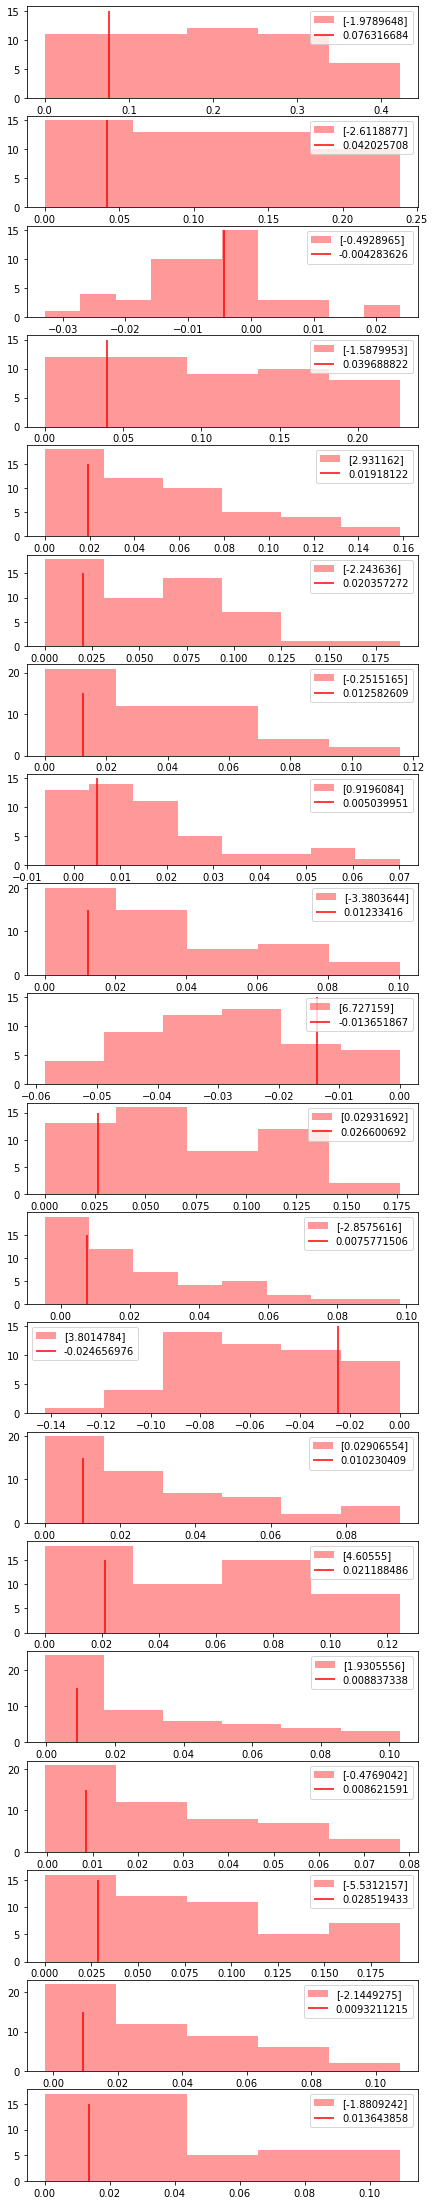

In [32]:
start = 0
N = 20
fig, ax = plt.subplots((N-start), 1, figsize=(7, (N-start)*2));
for i in range(start, N):    
    # 分布
    if args.num_actions >= 2:
        sns.distplot(dist_hist[i][1], color='red', kde=False, ax=ax[i - start], label=str(reward_hist[i]))
        dist = dist_hist[i][1]
    else:
        sns.distplot(dist_hist[i][0]*cumulative_density, color='red', kde=False, ax=ax[i - start], label=str(reward_hist[i]))
        dist = dist_hist[i][0]
    
    
    # 期待値
    mean = np.round(dist.mean(), 10)
    ax[i - start].vlines(mean, ymin=0, ymax=15, color='red', label=str(mean))
    
    
    # sharpe ratio
    sr = np.round(dist.mean() / dist.std(), 3)
    
    

    print('i = ', i,
              '実際:', reward_hist[i],
              '平均:', mean,
              'Sharpe Ratio:', sr)
    
    ax[i-start].legend()
#     ax[i-start].set_xlim(-0.05, 0.05)


In [29]:
dist

array([0.00289276, 0.00844269, 0.00876035, 0.00497634, 0.00305532,
       0.01599177, 0.00743526, 0.01418434, 0.0067708 , 0.01025999,
       0.01207271, 0.0134085 , 0.00740122, 0.0081556 , 0.0135694 ,
       0.01345747, 0.00915885, 0.01872108, 0.01899407, 0.01366336,
       0.01971054, 0.01372335, 0.01023343, 0.01707661, 0.01207742,
       0.01292797, 0.01593154, 0.01097647, 0.01088131, 0.01342798,
       0.00744037, 0.01964675, 0.01151524, 0.02111723, 0.01388799,
       0.01968464, 0.02052169, 0.01124084, 0.01660983, 0.01363667,
       0.01218856, 0.01805881, 0.00857423, 0.02070835, 0.02031119,
       0.01971914, 0.02121592, 0.01535838, 0.01564728, 0.0222955 ,
       0.01811962], dtype=float32)